<a href="https://www.kaggle.com/code/mastersniffer/breast-cancer?scriptVersionId=137726777" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
## Making essential imports
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
EPOCHS = 60

# Data Loader

In [3]:
# The code is defining a frame object called `frameObjTrain` which has two empty lists, `img` and `mask`, 
# to store image and mask data respectively.
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    """
     Loads data from images and masks. This function is used to load image and mask data from images and masks.
     
     @param frameObj - Dictionary to store data in. If None is passed a new dictionary will be created
     @param imgPath - Path to the images.
     @param maskPath - Path to the masks. It is assumed that the images are in png format
     @param shape - Shape of the image.
     
     @return Dictionary with loaded data. If None is passed a new dictionary will be created
    """
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = [imgNames[i].split(')')[0] for i in range(len(imgNames))]
    unames = list(set(unames))

    # Add the names and mask names to the names and mask names.
    for uname in unames:
        names.append(f'{uname}).png')
        maskNames.append(f'{uname})_mask.png')

    imgAddr = f'{imgPath}/'
    maskAddr = f'{maskPath}/'

    # Draw all images and masks in the frameObj.
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [4]:
# The code is loading benign and malignant samples of breast ultrasound images and storing them in the 
# `framObjTrain` object. The `LoadData` function is used to load the 
# images and masks from the specified paths (`imgPath` and `maskPath`) and resize them to a shape of 256x256 pixels. 
# The loaded samples are then added to the `framObjTrain` object.

framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                        , maskPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                        , shape = 256)

# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                        , maskPath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                        , shape = 256)

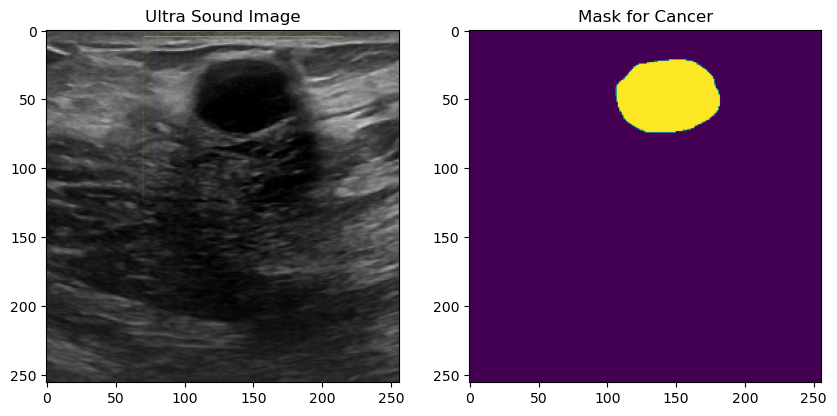

In [5]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

# Model Defination

In [6]:
# The `Conv2dBlock` function creates a convolutional block consisting of two convolutional 
# layers with batch normalization and ReLU activation. It takes an input tensor, 
# the number of filters in the convolutional block, the kernel size, and a flag indicating 
# whether to perform batch normalization. It returns the output tensor after passing through the convolutional block.
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    """
     Creates a conv block. It is assumed that the input tensor has been preprocessed by the block before.
     
     @param inputTensor - The input tensor to the block. Must be preprocessed by the block
     @param numFilters - The number of filters in the convolution block
     @param kernelSize - The
     @param doBatchNorm
    """
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    # Batch normalization. If doBatchNorm is true batch normalization is performed.
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    # Batch normalization. If doBatchNorm is true batch normalization is performed.
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    """
     Give me unet convolutions. It takes a batch of images and groups them into numFilters * 2 convolutions
     
     @param inputImage - The input image to be convoluted
     @param numFilters - The number of filters in the convolutional layers
     @param droupouts - The number of groupouts to be applied
     @param doBatchNorm - Whether to batch - normalize the input
     
     @return A tuple of ( Conv2dBlock Path )
    """
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    return tf.keras.Model(inputs = [inputImage], outputs = [output])

# Model Instantiation

In [7]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

# Training For 60 Epochs

In [8]:
%%time

# The code is fitting a transformer model to an image dataset. 
# It measures the time taken for the fitting process using the `%%time` magic command. 
# The `fit` function is called on the `myTransformer` object, passing in the image data (`framObjTrain['img']`) 
# and the corresponding mask data (`framObjTrain['mask']`). The fitting process is performed for a 
# specified number of epochs (`EPOCHS`) with no verbosity (`verbose = 0`). 
# Additionally, the fitting process is parallelized using 4 workers and multiprocessing is enabled. 
# The return value of the `fit` function is stored in the `retVal` variable.

retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = EPOCHS, verbose = 0,
                          workers=4,
                          use_multiprocessing=True)

CPU times: user 15h 3min 2s, sys: 1h 38min 9s, total: 16h 41min 12s
Wall time: 4h 53min 29s


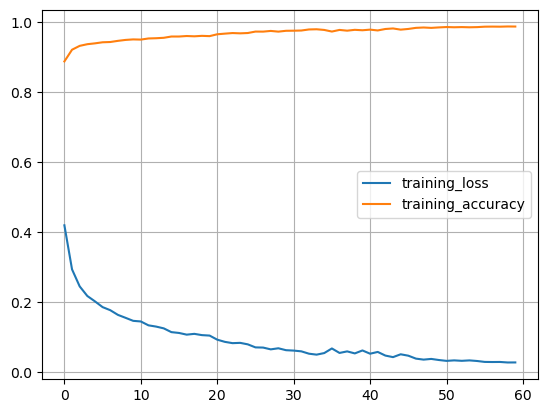

In [9]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

# Testing

In [10]:
def predict16(valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][:16]
    mask = valMap['mask'][:16]

    imgProc = img[:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    _extracted_from_Plotter_4(1, img, ' image')
    _extracted_from_Plotter_4(2, predMask, 'Predicted mask')
    _extracted_from_Plotter_4(3, groundTruth, 'Actual mask')


# TODO Rename this here and in `Plotter`
def _extracted_from_Plotter_4(arg0, arg1, arg2):
    plt.subplot(1, 3, arg0)
    plt.imshow(arg1)
    plt.title(arg2)

1/1 [==============================] - 2s 2s/step


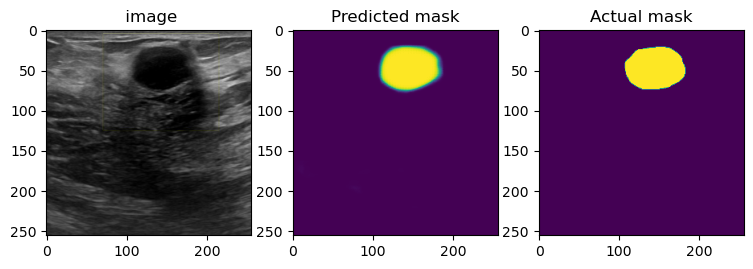

In [11]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

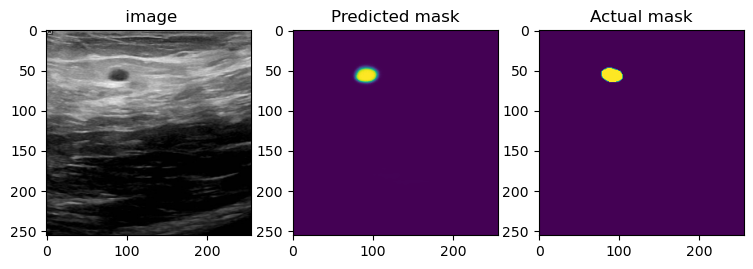

In [12]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

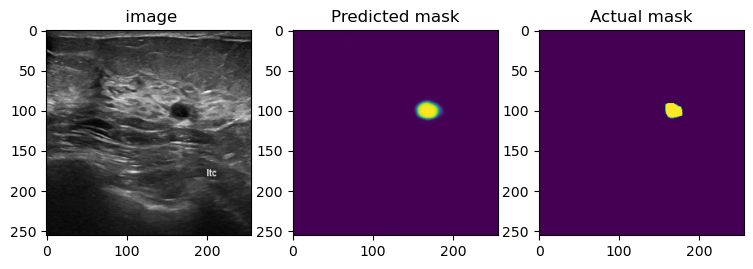

In [13]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

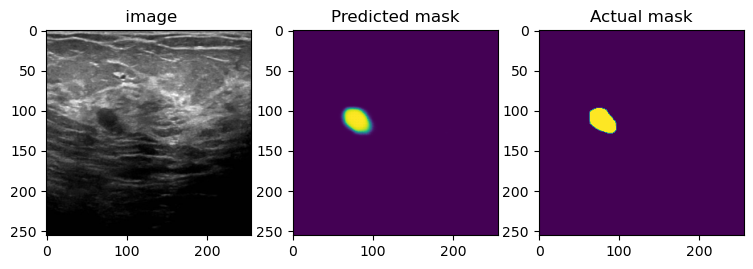

In [14]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

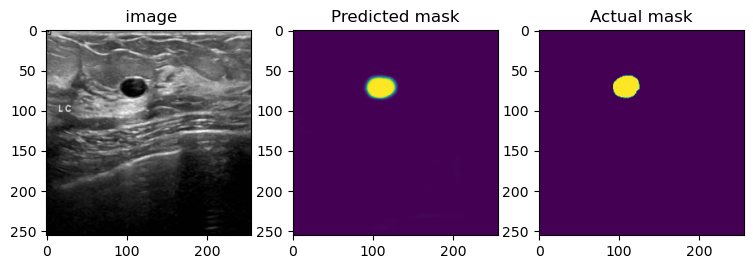

In [15]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

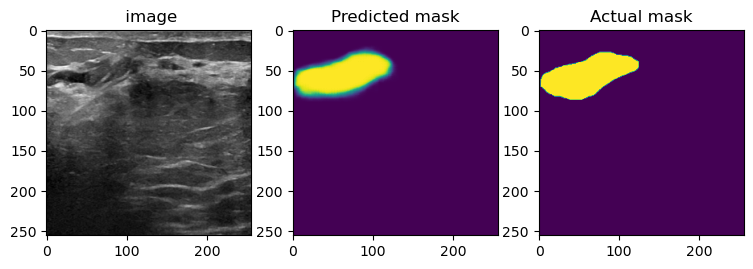

In [16]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

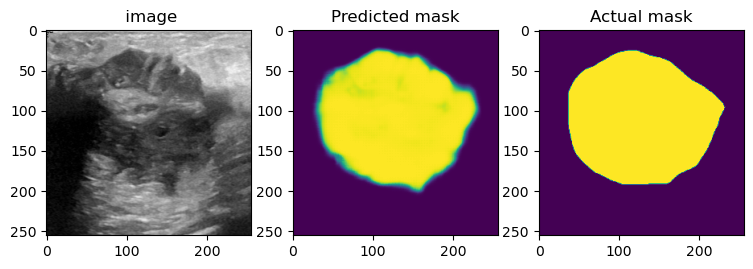

In [17]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

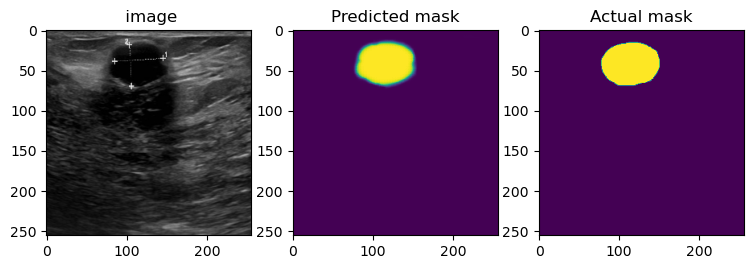

In [18]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

# Saving Model

In [19]:
myTransformer.save('BreastCancerSegmentor.h5')

## What about another way of solving this problem by labeling what is there ?

In [20]:
dir_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
IMAGE_SHAPE = (224, 224)

## Build Functions
create methods to make the code more organized

In [21]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

### Read the files from each dirctory
read all file from the three directories 'benign', 'malignant' and 'normal'

In [22]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(1578, 1578)

as we see, we have 1578 images in all dataset, BUT there are mask images which is not suitable for training with original images, so we will remove all the mask images from the dataset

### Remove any mask image from files

In [23]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

As we see, after removing the mask images the rest of dataset is 780 images which is not enough at all for training model from scratch, so we'll use **EfficientNetB7** model for Transfer Learning
### Prepare the images
prepare the images to be suitable as input for efficientnet model

In [24]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for file, label in zip(selected_files, selected_labels):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


### Prepare the target for splitting
* convert the images to numpy array for better computation
* encode the label to convert categorical names to numbers

In [25]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


**Split the data to train and test**

In [26]:
x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

### Build the Model
* create ResNet152V2 Model
* don't include_top layers to take only the features of the model
* freeze all layer weights of the model
* append my own layers for Transfer Learning
* compile my own model after Transfer Learning

In [27]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

234545216/234545216 [==============================] - 9s 0us/step


### Train the model

In [28]:
%%time

# Trains and returns incept_model. fit ( x_train y_train )
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/60
22/22 [==============================] - 172s 7s/step - loss: 1.2066 - sparse_categorical_accuracy: 0.4145 - val_loss: 1.4351 - val_sparse_categorical_accuracy: 0.1923
Epoch 2/60
22/22 [==============================] - 159s 7s/step - loss: 1.0778 - sparse_categorical_accuracy: 0.4972 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.6538
Epoch 3/60
22/22 [==============================] - 157s 7s/step - loss: 1.0014 - sparse_categorical_accuracy: 0.5598 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.5897
Epoch 4/60
22/22 [==============================] - 157s 7s/step - loss: 0.9675 - sparse_categorical_accuracy: 0.5783 - val_loss: 1.2800 - val_sparse_categorical_accuracy: 0.5897
Epoch 5/60
22/22 [==============================] - 151s 7s/step - loss: 0.9134 - sparse_categorical_accuracy: 0.6097 - val_loss: 1.0571 - val_sparse_categorical_accuracy: 0.5897
Epoch 6/60
22/22 [==============================] - 158s 7s/step - loss: 0.9041 - sparse_categorical_accu

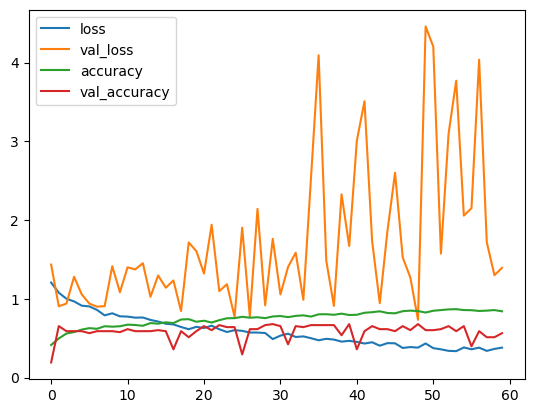

In [29]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

### Evaluate the model

In [30]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 14s 4s/step - loss: 1.3938 - sparse_categorical_accuracy: 0.5641


[1.3938233852386475, 0.5641025900840759]

### Make the last 100 layers as trainable

In [31]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

### Train the model again

In [32]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/60
22/22 [==============================] - 170s 7s/step - loss: 0.2487 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.8340 - val_sparse_categorical_accuracy: 0.7564
Epoch 2/60
22/22 [==============================] - 159s 7s/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.6575 - val_sparse_categorical_accuracy: 0.7308
Epoch 3/60
22/22 [==============================] - 158s 7s/step - loss: 0.2199 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.6346 - val_sparse_categorical_accuracy: 0.7821
Epoch 4/60
22/22 [==============================] - 157s 7s/step - loss: 0.1938 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.9214 - val_sparse_categorical_accuracy: 0.7308
Epoch 5/60
22/22 [==============================] - 158s 7s/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.8205
Epoch 6/60
22/22 [==============================] - 159s 7s/step - loss: 0.2001 - sparse_categorical_accu

### Evaluate the model

In [33]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 15s 4s/step - loss: 1.8006 - sparse_categorical_accuracy: 0.6538


[1.8006057739257812, 0.6538461446762085]

There are some imporovement after fine-tuning the last 100 layers, so for more epochs and better learning rate maybe the accuracy gets better

### Predict the model

In [34]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

1/1 [==============================] - 3s 3s/step


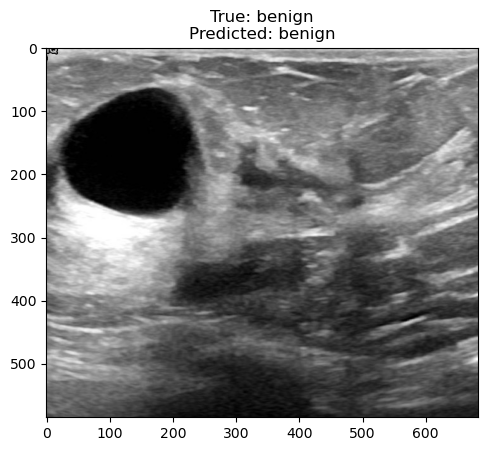

In [35]:
predict_image(f'{dir_path}benign/benign (10).png', 'benign')

1/1 [==============================] - 0s 289ms/step


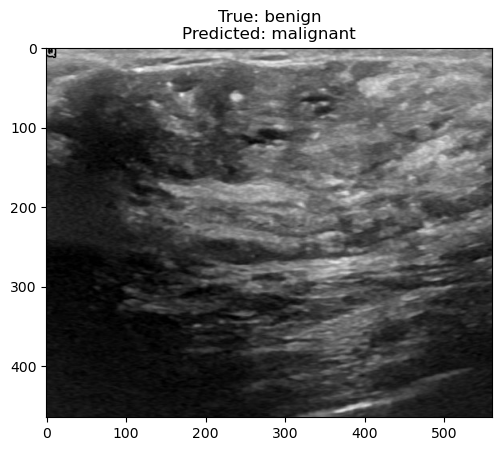

In [36]:
predict_image(f'{dir_path}benign/benign (85).png', 'benign')

1/1 [==============================] - 0s 286ms/step


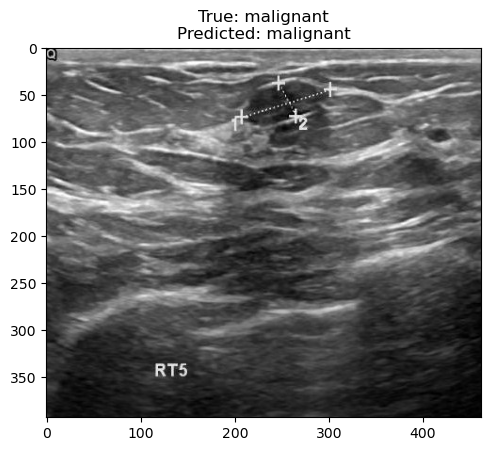

In [37]:
predict_image(f'{dir_path}malignant/malignant (10).png', 'malignant')